In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as npl

Work flow for optimization

1. Given coordinates and velocities calculate energy.
2. Calculate the gradient of the Energy with respect to the coordinates and velocites at the curent coordinates and velocites. (Analytically or numerically)
3. Update the coordinates and velocites.
4. Repeat until updated energy is 'close enough' to current energy.

We just need to update the coordinates and velocites of the electrons and leave the nuclei coordiantes alone and velocites at 0.

Compute Gradient of Energy

In [ ]:
#partial of the energy with respect to the coordiates of i th electron
def dE_dri(elecCoors, nucCoors, nucCharges,elecInd):
  e =1 #electon charge
  C = 1 #1/(4 pi e0)
  dE = np.zeros((1,3))
  for i in range(len(nucCoors)):
    # print('dE',dE)
    # print('stuff',e*nucCharges[i]/(npl.norm(elecCoors[elecInd]-nucCoors[i])**2)*(elecCoors[elecInd]-nucCoors[i]))
    dE -= e*nucCharges[i]/(npl.norm(elecCoors[elecInd]-nucCoors[i])**3)*(nucCoors[i]-elecCoors[elecInd])
  
  for i in range(len(elecCoors)):
    if i != elecInd:
      dE += (e**2)/(npl.norm(elecCoors[elecInd]-elecCoors[i])**3) *(elecCoors[i]-elecCoors[elecInd])
  return dE[0]

#partial derivative of the energy with resepct the velocity of i th electron
def dE_dvi(elecVel, elecInd):
  mE = 1 #mass of electron
  return mE*elecVel[elecInd]

#returns the gradient of the energy with respect to electronic coordinates and then electronic velocities
def gradE(elecCoors, nucCoors, nucCharges,elecVel):
  gradElecCoors = []
  gradElecVel = []
  for i in range(len(elecCoors)):
    gradElecCoors.append(dE_dri(elecCoors, nucCoors, nucCharges,i))
  for i in range(len(elecVel)):
    gradElecVel.append(dE_dvi(elecVel, i))
  return np.array(gradElecCoors), np.array(gradElecVel)


Compute Energy

In [ ]:
def energy(elecCoors, nucCoors, nucCharges, elecVel):
  E = 0
  e = 10
  C = 1
  mE = 1
  # print('start')
  for i in range(len(elecCoors)):
    for j in range(len(nucCoors)):
      E -= nucCharges[j]*e*C/abs(npl.norm(elecCoors[i]-nucCoors[j]))
      # print(E)
  # print('elec')
  for i in range(len(elecCoors)):
    E += 0.5 *mE * npl.norm(elecVel[i])**2
    for j in range(i+1,len(elecCoors)):
      E += C*e**2/abs(npl.norm(elecCoors[i]-elecCoors[j]))
      # print(E)
  # print('end')
  return E


  


Optimization

In [ ]:
def gradDescent(initElecCoors,initNucCoors,nucCharges,initElecVel,iter,tol,lr):

  E = energy(initElecCoors,initNucCoors,nucCharges,initElecVel)
  # print(initElecCoors)
  gradElecCoors, gradElecVel = gradE(initElecCoors,initNucCoors,nucCharges,initElecVel)
  newElecCoors, newElecVel = initElecCoors-lr*gradElecCoors, initElecVel-lr*gradElecVel
  newE = energy(newElecCoors,initNucCoors,nucCharges,newElecVel)
  count =0
  while abs(newE-E)>tol:
    E = newE
    count += 1
    if count % 1000 ==0:
      print(count,newE)
    gradElecCoors, gradElecVel = gradE(newElecCoors,initNucCoors,nucCharges,newElecVel)
    newElecCoors, newElecVel = initElecCoors-lr*gradElecCoors, initElecVel-lr*gradElecVel
    newE = energy(newElecCoors,initNucCoors,nucCharges,newElecVel)
    # print(newE)
    if count > iter:
      return "Did not converge. Last energy diff was "+ str(abs(newE-E)), newElecCoors, newElecVel
  print(count)
  return newE, newElecCoors, newElecVel


def gradDesMomentum(initElecCoors,initNucCoors,nucCharges,initElecVel,iter,tol,lr,moment):
  E = energy(initElecCoors,initNucCoors,nucCharges,initElecVel)
  gradElecCoors, gradElecVel = gradE(initElecCoors,initNucCoors,nucCharges,initElecVel)
  vElecCoors, vElecVel = gradElecCoors, gradElecVel
  newElecCoors, newElecVel = initElecCoors-lr*vElecCoors, initElecVel-lr*vElecVel
  newE = energy(newElecCoors,initNucCoors,nucCharges,newElecVel)
  count =0
  while abs(newE-E)>tol:
    E = newE
    count += 1
    gradElecCoors, gradElecVel = gradE(newElecCoors,initNucCoors,nucCharges,newElecVel)
    vElecCoors, vElecVel = vElecCoors*moment + gradElecCoors, vElecVel*moment + gradElecVel
    newElecCoors, newElecVel = initElecCoors-lr*vElecCoors, initElecVel-lr*vElecVel
    newE = energy(newElecCoors,initNucCoors,nucCharges,newElecVel)
    if count % 1000 ==0:
      print(count,newE)
    if count > iter:
      return "Did not converge. Last energy diff was "+ str(abs(newE-E)), newElecCoors, newElecVel
  print(count)
  return newE, newElecCoors, newElecVel

def adam(initElecCoors,initNucCoors,nucCharges,initElecVel,iter,tol,lr,betas):
  count = 1
  E = energy(initElecCoors,initNucCoors,nucCharges,initElecVel)

  gradElecCoors, gradElecVel = gradE(initElecCoors,initNucCoors,nucCharges,initElecVel)

  fBiasElecCoors = betas[0]*0 + (1-betas[0])*gradElecCoors
  sBiasElecCoors = betas[1]*0 + (1-betas[1])*gradElecCoors**2
  fBiasElecVel = betas[0]*0 + (1-betas[0])*gradElecVel
  sBiasElecVel = betas[1]*0 + (1-betas[1])*gradElecVel**2

  fMomElecCoors = fBiasElecCoors/(1-betas[0]**count)
  sMomElecCoors = sBiasElecCoors/(1-betas[1]**count)
  fMomElecVel = fBiasElecVel/(1-betas[0]**count)
  sMomElecVel = sBiasElecVel/(1-betas[1]**count)

  newElecCoors, newElecVel = initElecCoors+lr*fMomElecCoors/np.sqrt(sMomElecCoors+10**-7), initElecVel-lr*fMomElecVel/np.sqrt(sMomElecVel+10**-7)
  newE = energy(newElecCoors,initNucCoors,nucCharges,newElecVel)
  print(newE)
  while abs(newE-E)>tol:
    count += 1
    E = newE
    gradElecCoors, gradElecVel = gradE(newElecCoors,initNucCoors,nucCharges,newElecVel)
    

    fBiasElecCoors = betas[0]*fBiasElecCoors + (1-betas[0])*gradElecCoors
    sBiasElecCoors = betas[1]*sBiasElecCoors + (1-betas[1])*gradElecCoors**2
    fBiasElecVel = betas[0]*fBiasElecVel + (1-betas[0])*gradElecVel
    sBiasElecVel = betas[1]*sBiasElecVel + (1-betas[1])*gradElecVel**2

    fMomElecCoors = fBiasElecCoors/(1-betas[0]**count)
    sMomElecCoors = sBiasElecCoors/(1-betas[1]**count)

    fMomElecVel = fBiasElecVel/(1-betas[0]**count)
    sMomElecVel = sBiasElecVel/(1-betas[1]**count)

    oldElecCoors, oldElecVel = newElecCoors, newElecVel

    newElecCoors, newElecVel = newElecCoors+lr*fMomElecCoors/np.sqrt(sMomElecCoors+10**-7), newElecVel-lr*fMomElecVel/np.sqrt(sMomElecVel+10**-7)

    newE = energy(newElecCoors,initNucCoors,nucCharges,newElecVel)
    if count % 1000 ==0:
      print(count,newE)
    if count > iter:
      return "Did not converge. Last energy diff was "+ str(abs(newE-E)), newElecCoors, newElecVel
  print(count)
  return newE, newElecCoors, newElecVel


Run Optimization

In [ ]:
initElecCoors = 1*np.array([[0.5,0.0,0.0],[0.0,0.5,0.0],[0.0,0.0,0.5],[-0.5,0.0,0.0],[0.0,-0.5,0.0],[0.0,0.0,-0.5],
                          [1.25,0.75,0],[-1.25,0.75,0.0]])


initNucCoors = np.array([[0.0,0.0,0.0],[0.75,0.75,0],[-0.75,0.75,0]])

nucCharges = [6,1,1]

initElecVel = 0*np.array([[0.0,1.0,0.0],[1.0,0.0,0.0],[0.0,-1.0,0.0],[0.0,0.0,1.0],[-1.0,0.0,0.0],[0.0,0.0,-1.0],
                          [0.0,0.0,1.0],[0.0,0.0,-1.0]])

iter,tol,lr = 100000, 0.0000001, 0.00001


newE, newElecCoors, newElecVel = gradDescent(initElecCoors,initNucCoors,nucCharges,initElecVel,iter,tol,lr)

print(newE)
# print(newElecCoors)
# print(newElecVel)
print('Done Grad Des')

newE, newElecCoors, newElecVel = gradDesMomentum(initElecCoors,initNucCoors,nucCharges,initElecVel,iter,tol,lr,0.9)

print(newE)
# print(newElecCoors)
# print(newElecVel)
print('Done Mome')

newE, newElecCoors, newElecVel = adam(initElecCoors,initNucCoors,nucCharges,initElecVel,iter,tol,lr,[0.5,0.5])

print(newE)
print(newElecCoors)
print(newElecVel)
print('Done adam')

3
1896.24256341129
Done Grad Des
147
1900.4494598396338
Done Mome
1895.7515455734033
1000 1868.1771430622593
2000 1842.064532593713
3000 1817.5186030482785
4000 1794.4460027093958
5000 1772.697079188692
6000 1752.1405330991843
7000 1732.6610002322695
8000 1714.1569780042273
9000 1696.5390390687623
10000 1679.728287637
11000 1663.6550228907897
12000 1648.2575802512229
13000 1633.4813260104675
14000 1619.2777844901461
15000 1605.6038797995016
16000 1592.4212766541957
17000 1579.6958067250457
18000 1567.3969687095216
19000 1555.4974918200437
20000 1543.9729537072503
21000 1532.8014450137503
22000 1521.9632738116711
23000 1511.4407041319923
24000 1501.2177236619345
25000 1491.27983647818
26000 1481.613877405271
27000 1472.2078452428839
28000 1463.0507526917895
29000 1454.1324913215071
30000 1445.4437103576229
31000 1436.9757084158414
32000 1428.7203375684169
33000 1420.6699192940011
34000 1412.8171719367201
35000 1405.1551492925212
36000 1397.6771898643703
37000 1390.376876201649
38000 138

Optimization Test Functions

In [ ]:
def rosenbrock(x):
  f = 0
  for i in range(len(x)-1):
    f += 100*(x[i+1]-x[i]**2)**2 + (1-x[i])**2
  return f

def gradRose(x):
  grad = np.zeros_like(x)
  grad[0] = -200*(x[1]-x[0]**2)*2*x[0] - 2*(1-x[0])
  for i in range(1,len(x)-2):
    grad[i] = -200*(x[i+1]-x[i]**2)*2*x[0] - 2*(1-x[i]) +200*(x[i]-x[i-1]**2)
  grad[len(x)-1] = 200*(x[len(x)-1]-x[len(x)-2]**2)
  return grad

def minirosenbrock(x):
  f = 0
  for i in range(len(x)-1):
    f += (x[i+1]-x[i]**2)**2 + 1e-2*(1-x[i])**2
  return f

def gradminiRose(x):
  grad = np.zeros_like(x)
  grad[0] = -2*(x[1]-x[0]**2)*2*x[0] - 2e-2*(1-x[0])
  for i in range(1,len(x)-2):
    grad[i] = -2*(x[i+1]-x[i]**2)*2*x[0] - 2e-2*(1-x[i]) +2*(x[i]-x[i-1]**2)
  grad[len(x)-1] = 2*(x[len(x)-1]-x[len(x)-2]**2)
  return grad

def rastrig(x):
  f = 10 * len(x)
  for i in range(len(x)):
    f += x[i]**2 -10 *np.cos(2*np.pi*x[i])
  return f

def gradRas(x):
  grad = np.zeros_like(x)
  for i in range(len(x)):
    grad[i] = 2*x[i] + 10 * np.sin(2*np.pi*x[i])*2*np.pi
  return grad

def spher(x):
  f = 0
  for i in range(len(x)):
    f += x[i]**2
  return f

def gradSpher(x):
  grad = np.zeros_like(x)
  for i in range(len(x)):
    grad[i] = 2*x[i]
  return grad

x = np.array([1,1])

print(rastrig(x))
print(gradRas(x))

2.0
[1 1]


Generalized Optimizations

In [ ]:
#def gradDescent(initX,f,grad,iter,tol,lr):
#
#  oldF = f(initX)
#  gradInit = grad(initX)
#  newX = initX-lr*gradInit
#  newF = f(newX)
#  count =0
#  while abs(newF-oldF)>tol:
#    oldF = newF
#    count += 1
#    if count % 1000 ==0:
#      print(count,newF)
#    newGrad = grad(newX)
#    newX = newX-lr*newGrad
#    newF = f(newX)
#    if count > iter:
#      return "Did not converge. Last function diff was "+ str(abs(newF-oldF)),newX
#  print(count)
#  return newF, newX

def gradDescent(initX,f,grad,iter,tol,lr):
  #reimplemented to keep track of each step
  x = initX
  listX = [x]
  F = f(x)
  
  oldF = F
  count =0
  while count <= iter:
    count += 1

    gradF = grad(x)
    x = x-lr*gradF
    listX += [x]
    F = f(x)
    if abs(oldF-F) < tol:
      #print(count,F)
      return F, x, listX
    oldF = F
  return "Did not converge. Last function diff was "+ str(abs(F-oldF)),x

#def gradDesMomentum(initX,f,grad,iter,tol,lr,moment):
#  oldF = f(initX)
#  gradInit = grad(initX)
#  vX = gradInit
#  newX = initX-lr*vX
#  newF = f(newX)
#  count =0
#
#  while abs(newF-oldF)>tol:
#    oldF = newF
#    if count % 1000 ==0:
#      print(count,newF)
#    count += 1
#    newGrad = grad(newX)
#    vX = vX*moment + grad(newX)
#    newX = newX-lr*vX
#    newF = f(newX)
#    if count > iter:
#      return "Did not converge. Last function diff was "+ str(abs(newF-oldF)), newX
#  print(count)
#  return newF, newX

def gradDesMomentum(initX,f,grad,iter,tol,lr,moment):
  #reimplemented to keep track of each step
  x = initX
  listX = [x]
  F = f(x)
  
  oldF = F
  vX = 0
  count =0
  while count <= iter:
    count += 1

    gradF = grad(x)
    vX = vX*moment + gradF
    x = x-lr*vX
    listX += [x]
    F = f(x)
    if abs(oldF-F) < tol:
      #print(count,F)
      return F, x, listX
    oldF = F
  return "Did not converge. Last function diff was "+ str(abs(F-oldF)),x

#def adam(initX,f,grad,iter,tol,lr,betas):
#  count = 1
#  oldF = f(initX)
#
#  gradInit = grad(initX)
#
#  fBiasX = betas[0]*0 + (1-betas[0])*gradInit
#  sBiasX = betas[1]*0 + (1-betas[1])*gradInit**2
#
#  fMomX = fBiasX/(1-betas[0]**count)
#  sMomX = sBiasX/(1-betas[1]**count)
#
#  newX = initX-lr*fMomX/np.sqrt(sMomX+10**-7)
#  newF = f(newX)
#
#  while abs(newF-oldF)>tol:
#    count += 1
#    oldF = newF
#    newGrad = grad(newX)
#    
#
#    fBiasX = betas[0]*fBiasX + (1-betas[0])*newGrad
#    sBiasX = betas[1]*sBiasX + (1-betas[1])*newGrad**2
#
#    fMomX = fBiasX/(1-betas[0]**count)
#    sMomX = sBiasX/(1-betas[1]**count)
#
#    newX = newX-lr*fMomX/np.sqrt(sMomX+10**-7)
#
#    newF = f(newX)
#    if count % 1000 ==0:
#      print(count,newF)
#    if count > iter:
#      return "Did not converge. Last function diff was "+ str(abs(newF-oldF)), newX
#  print(count)
#  return newF, newX

def adam(initX,f,grad,iter,tol,lr,betas):
  #reimplemented to keep track of each step
  x = initX
  listX = [x]
  F = f(x)
  
  oldF = F
  fBiasX,sBiasX = 0,0
  count =0
  while count <= iter:
    count += 1

    gradF = grad(x)
    
    fBiasX = betas[0]*fBiasX + (1-betas[0])*gradF
    sBiasX = betas[1]*sBiasX + (1-betas[1])*gradF**2

    fMomX = fBiasX/(1-betas[0]**count)
    sMomX = sBiasX/(1-betas[1]**count)

    x = x-lr*fMomX/np.sqrt(sMomX+10**-7) # why is this 10^-7 here? To not divide by zero makes for bad behavior when grad gets small
    listX += [x]
    F = f(x)
    if abs(oldF-F) < tol:
      #print(count,F)
      return F, x, listX
    oldF = F
  return "Did not converge. Last function diff was "+ str(abs(F-oldF)),x

In [ ]:
def plotContour(f,xi,title):
  #series of value pairs xi
  xmin,xmax,ymin,ymax = 1.5,1.5,1.5,1.5
  for x in xi:
    if x[0] < xmin:
      xmin = x[0]
    if x[0] > xmax:
      xmax = x[0]
    if x[1] < ymin:
      ymin = x[1]
    if x[1] > ymax:
      ymax = x[1]

  margin = 2
  points = 100
  x = np.linspace(xmin-margin,xmax+margin,points)
  y = np.linspace(ymin-margin,ymax+margin,points)
  X,Y = np.meshgrid(x,y)

  Z = f([X,Y])
  fig,ax = plt.subplots()

  xiT = np.transpose(xi)
  ax.contourf(X, Y, Z)
  ax.plot(xiT[0],xiT[1], color='white')
  ax.plot(xi[-1][0], xi[-1][1], marker="o", markersize=7,markeredgecolor="red",markerfacecolor="white")
  ax.set_title(title)
  ax.set_xlabel("x_1")
  ax.set_ylabel("x_2")

def testFunctionDesc(f,grad,name,x=np.array([1.5,1.5]),iter=10000,tol=10**-6,lr=10**-3):
  print(name)
  results = [
      gradDescent(x,f,grad,iter,tol,lr),
      gradDesMomentum(x,f,grad,iter,tol,lr,0.99),
      adam(x,f,grad,iter,tol,lr,[0.9,0.9])
  ]
  for i in range(3):
    print(results[i][0:2])
    if len(results[i]) == 3:
      plotContour(f,results[i][2],name + " Minimized Under " + ["Gradient Descent","Gradient Descent w/ Momentum", "Adam"][i])

def testIterationsByDistance(f,grad,name,count,x0=np.array([1.5,1.5]),vec=np.array([1.0,1.0]),iter=10000,tol=10**-6,lr=10**-3):
  print(name)
  gDcount = []
  gMcount = []
  ADAMcount = []
  for n in range(count):
    result = gradDescent(x0+vec*n,f,grad,iter,tol,lr)
    if len(result) != 3:
      break
    gDcount += [len(result[2])]
  for n in range(count):
    result = gradDesMomentum(x0+vec*n,f,grad,iter,tol,lr,0.99)
    if len(result) != 3:
      break
    gMcount += [len(result[2])]
  for n in range(count):
    result = adam(x0+vec*n,f,grad,iter,tol,lr,[0.9,0.9])
    if len(result) != 3:
      break
    ADAMcount += [len(result[2])]
  xn = np.linalg.norm(vec)*range(count)
  plt.plot(xn[0:len(gDcount)],gDcount, color='blue')
  plt.title("Count Vs Distance Gradient Descent for " + name)
  plt.xlabel("Distance")
  plt.ylabel("Count")
  plt.show()
  plt.plot(xn[0:len(gMcount)],gMcount, color='red')
  plt.title("Count Vs Distance Gradient Descent w/ Momentum for " + name)
  plt.xlabel("Distance")
  plt.ylabel("Count")
  plt.show()
  plt.plot(xn[0:len(ADAMcount)],ADAMcount, color='green')
  plt.title("Count Vs Distance Adam for " + name)
  plt.xlabel("Distance")
  plt.ylabel("Count")
  plt.show()
  
def testIterationsPowByDistance(f,grad,name,count,x0=np.array([1.5,1.5]),vec=np.array([1.0,1.0]),iter=10000,tol=10**-6,lr=10**-3,pow=2,ylog=False,xlog=False):
  print(name)
  gDcount = []
  gMcount = []
  ADAMcount = []
  for n in range(count):
    result = gradDescent(x0+vec*n,f,grad,iter,tol,lr)
    if len(result) != 3:
      break
    gDcount += [len(result[2])]
  for n in range(count):
    result = gradDesMomentum(x0+vec*n,f,grad,iter,tol,lr,0.99)
    if len(result) != 3:
      break
    gMcount += [len(result[2])]
  for n in range(count):
    result = adam(x0+vec*n,f,grad,iter,tol,lr,[0.9,0.9])
    if len(result) != 3:
      break
    ADAMcount += [len(result[2])]
  xn = np.linalg.norm(vec)*range(count)
  plt.plot(xn[0:len(gDcount)],np.array(gDcount)**pow, color='blue')
  plt.title("Count Vs Distance Gradient Descent for " + name)
  plt.xlabel("Distance")
  plt.ylabel("Count")
  if (ylog):
    plt.semilogy()
  if (xlog):
    plt.semilogx()
  plt.show()
  plt.plot(xn[0:len(gMcount)],np.array(gMcount)**pow, color='red')
  plt.title("Count Vs Distance Gradient Descent w/ Momentum for " + name)
  plt.xlabel("Distance")
  plt.ylabel("Count")
  if (ylog):
    plt.semilogy()
  if (xlog):
    plt.semilogx()
  plt.show()
  plt.plot(xn[0:len(ADAMcount)],np.array(ADAMcount)**pow, color='green')
  plt.title("Count Vs Distance Adam for " + name)
  plt.xlabel("Distance")
  plt.ylabel("Count")
  if (ylog):
    plt.semilogy()
  if (xlog):
    plt.semilogx()
  plt.show()
  



Rose
(0.0013253185364518762, array([1.03637706, 1.07421982]))
(6.275676929720104e-05, array([1.0012757 , 1.00177117]))
(3.3103189029422586e-05, array([1.00571669, 1.01140104]))
Ras
(1.9899183935421334, array([0.99498518, 0.99498518]))
(0.002383955998542575, array([0.00245119, 0.00245119]))
(1.9899434503617712, array([0.99470588, 0.99470588]))
Spher
(0.00024908217924057114, array([0.0111598, 0.0111598]))
(0.0009123022696140682, array([0.02135769, 0.02135769]))
(2.598868234626752e-07, array([-0.00036048, -0.00036048]))


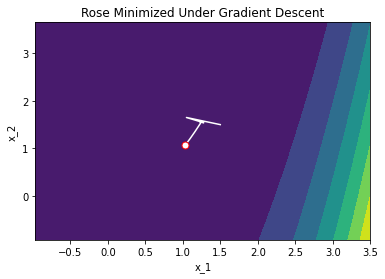

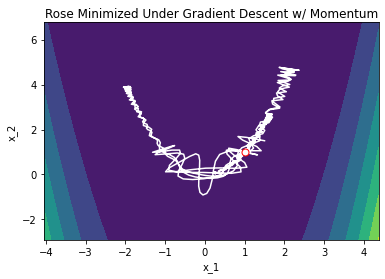

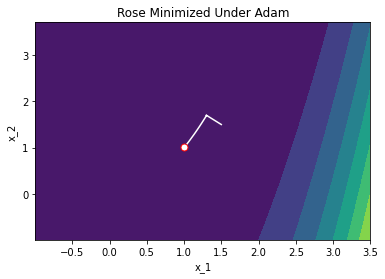

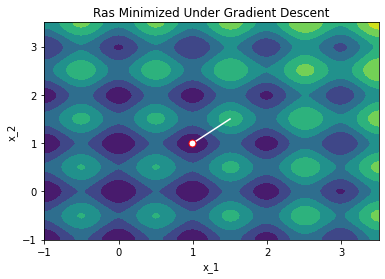

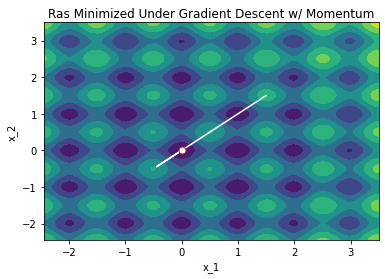

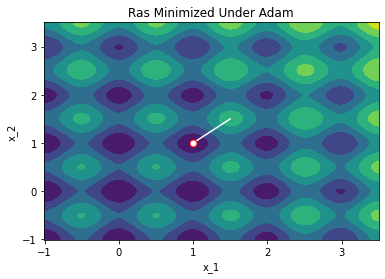

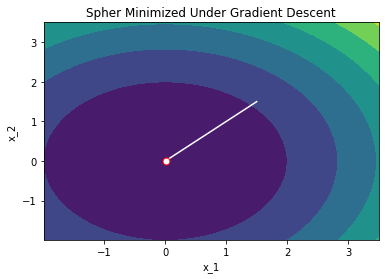

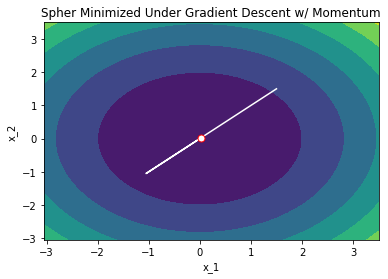

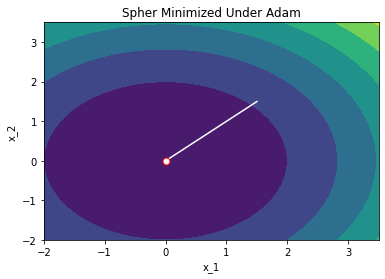

In [ ]:
testFunctionDesc(rosenbrock,gradRose,"Rose")
testFunctionDesc(rastrig,gradRas,"Ras")
testFunctionDesc(spher,gradSpher,"Spher")


#print('Spher')
#print(gradDescent(x,spher,gradSpher,200000,tol,lr)[0:2])
#print(gradDesMomentum(x,spher,gradSpher,100000,tol,lr,0.9)[0:2])
#print(adam(x,spher,gradSpher,100000,tol,lr,[0.9,0.9])[0:2])

Spher
301 2.3513110274074116e-05
864 0.0007621689108113366
209 2.9954611564950434e-06
(2.3513110274074116e-05, array([0.00342878, 0.00342878]))
(0.0007621689108113366, array([-0.01952138, -0.01952138]))
(2.9954611564950434e-06, array([0.00122382, 0.00122382]))
Spher
18738 0.0024989810175546864
474 0.03841976104061346
14976 1.2806224772787013e-05
(0.0024989810175546864, array([0.03534813, 0.03534813]))
(0.03841976104061346, array([0.13859971, 0.13859971]))
(1.2806224772787013e-05, array([0.00253044, 0.00253044]))


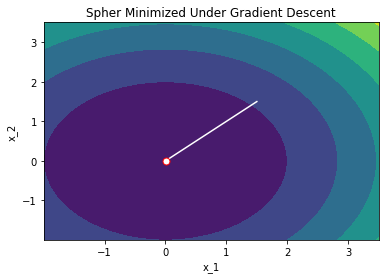

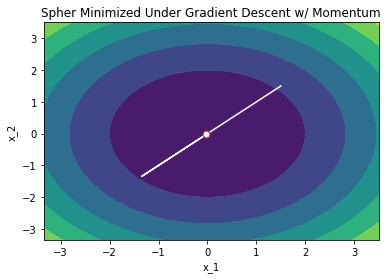

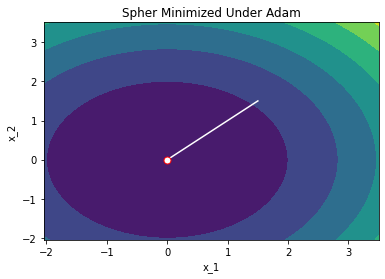

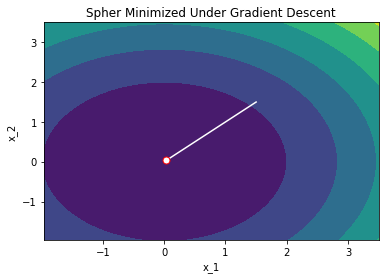

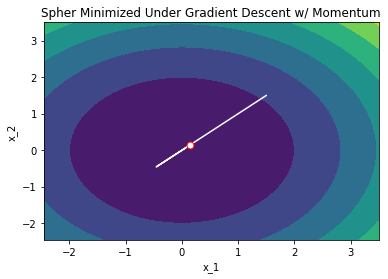

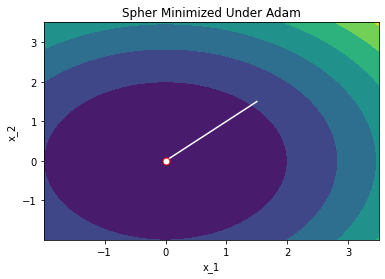

In [ ]:
testFunctionDesc(spher,gradSpher,"Spher",lr=10**-2)
testFunctionDesc(spher,gradSpher,"Spher",lr=10**-4,iter = 20000)

Spher
1 0.0
1 0.0
1 0.0
(0.0, array([0., 0.]))
(0.0, array([0., 0.]))
(0.0, array([0., 0.]))


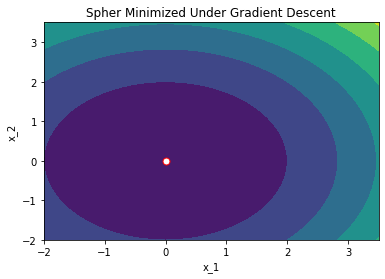

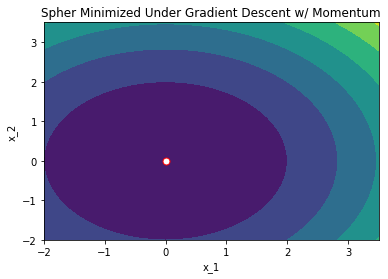

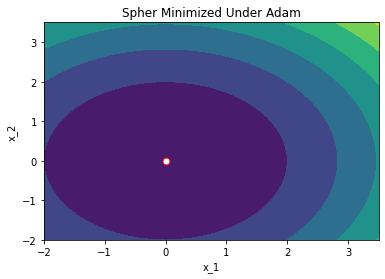

In [ ]:
testFunctionDesc(spher,gradSpher,"Spher",x=np.array([0,0]))

Spher
3598 2.492227120393704e-06
1166 2.2862067171471114e-08
1553 2.028955451063858e-06
(2.492227120393704e-06, array([0.00111629, 0.00111629]))
(2.2862067171471114e-08, array([-0.00010692, -0.00010692]))
(2.028955451063858e-06, array([-0.00100721, -0.00100721]))


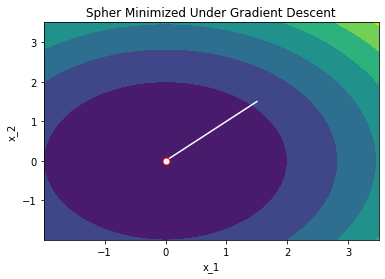

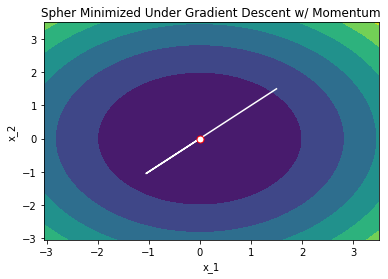

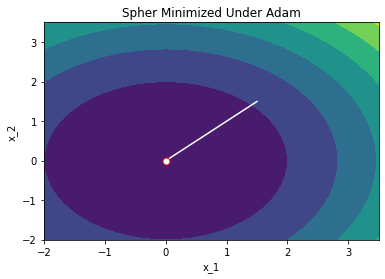

In [ ]:
testFunctionDesc(spher,gradSpher,"Spher",tol = 10**-8,iter = 100000000)

In [ ]:
#testFunctionDesc(energy,gradE,"Energy") ?

Energy


TypeError: ignored

Rose


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in double_scalars
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in double_scalars
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in double_scalars
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered 

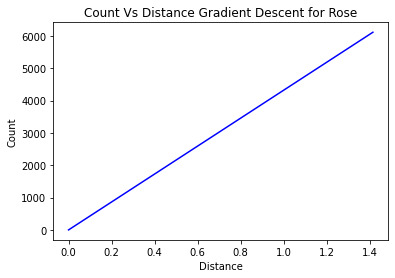

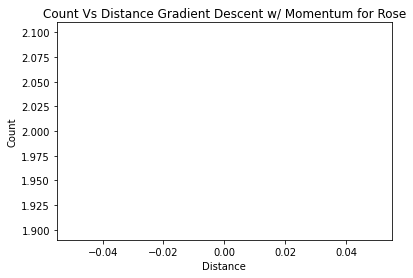

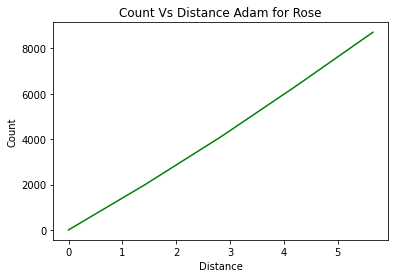

In [ ]:
testIterationsByDistance(rosenbrock,gradRose,"Rose",200,x0=np.array([1,1]))

Rose
(0.0013253185364518762, array([1.03637706, 1.07421982]))
(6.275676929720104e-05, array([1.0012757 , 1.00177117]))
(3.3103189029422586e-05, array([1.00571669, 1.01140104]))
Rose


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in power
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in double_scalars
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in add


(0.0011829373507967764, array([0.96563481, 0.93231019]))
('Did not converge. Last function diff was nan', array([nan, nan]))
(3.742324805664849e-05, array([1.00604997, 1.01204592]))
Rose


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in power
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in power
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in power
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


('Did not converge. Last function diff was nan', array([nan, nan]))
('Did not converge. Last function diff was nan', array([nan, nan]))
(0.00015076450828680968, array([1.01202232, 1.02393962]))


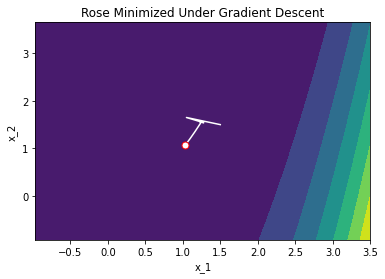

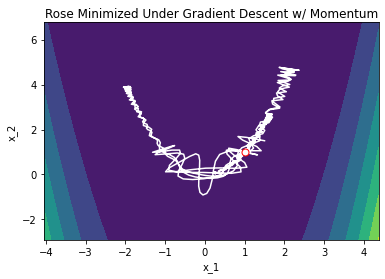

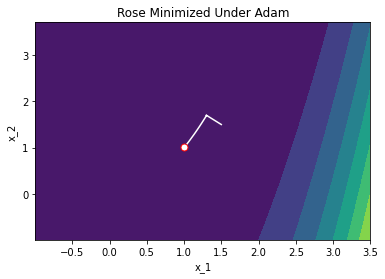

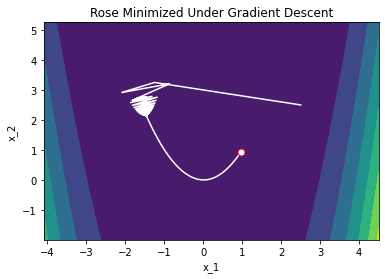

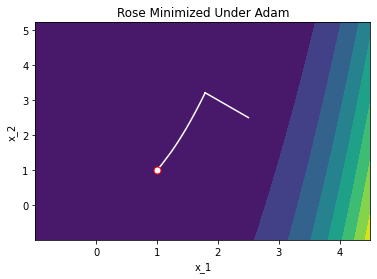

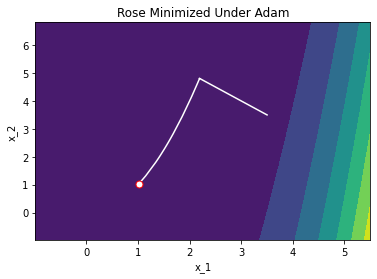

In [ ]:
testFunctionDesc(rosenbrock,gradRose,"Rose",x=np.array([1.5,1.5]))
testFunctionDesc(rosenbrock,gradRose,"Rose",x=np.array([2.5,2.5]))
testFunctionDesc(rosenbrock,gradRose,"Rose",x=np.array([3.5,3.5]))

In [ ]:
testIterationsByDistance(minirosenbrock,gradminiRose,"Rose",200,tol=1e-10,iter=1e5)

Rose


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in add


KeyboardInterrupt: ignored

Rose
('Did not converge. Last function diff was 0.0', array([1.19515976, 1.42910184]))
(1.1923715102109609e-07, array([0.9965497 , 0.99309747]))
(3.286216600305088e-09, array([1.0005728 , 1.00114821]))
Rose
('Did not converge. Last function diff was 0.0', array([1.5390642 , 2.37030281]))
(1.2058258620940936e-07, array([1.00346974, 1.00696536]))
(3.300873205146361e-09, array([1.00057407, 1.00115077]))
Rose
('Did not converge. Last function diff was 0.0', array([1.83018809, 3.35169902]))
(1.1916934829232272e-07, array([0.99655068, 0.99309943]))
(3.329402436238212e-09, array([1.00057655, 1.00115574]))


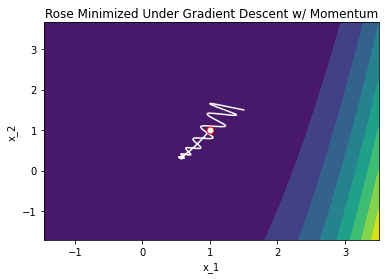

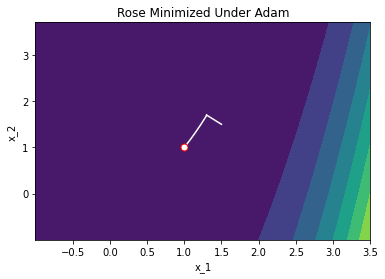

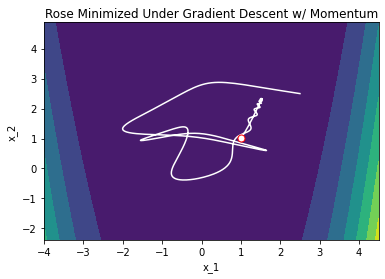

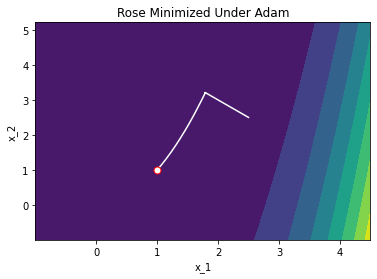

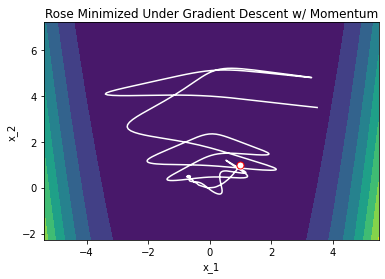

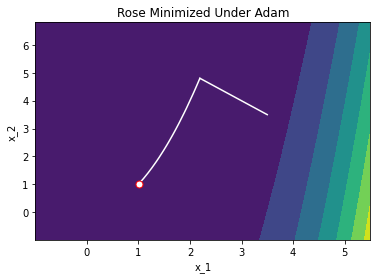

In [ ]:
testFunctionDesc(minirosenbrock,gradminiRose,"Rose",x=np.array([1.5,1.5]),tol=1e-10,iter=1e5)
testFunctionDesc(minirosenbrock,gradminiRose,"Rose",x=np.array([2.5,2.5]),tol=1e-10,iter=1e5)
testFunctionDesc(minirosenbrock,gradminiRose,"Rose",x=np.array([3.5,3.5]),tol=1e-10,iter=1e5)

Rose
('Did not converge. Last function diff was 0.0', array([ 3.50296695, 12.27427877]))
(1.1987920538363431e-17, array([1.00000003, 1.00000007]))
(3.3141744800650375e-19, array([1.00000001, 1.00000001]))
Rose


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in add


('Did not converge. Last function diff was 0.0', array([ 3.6331009 , 13.20297853]))
('Did not converge. Last function diff was nan', array([nan, nan]))
(3.2833356880579537e-19, array([1.00000001, 1.00000001]))


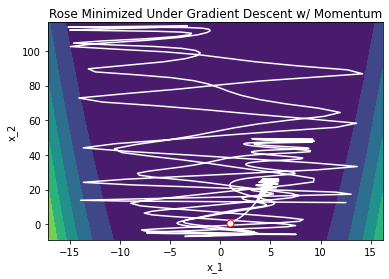

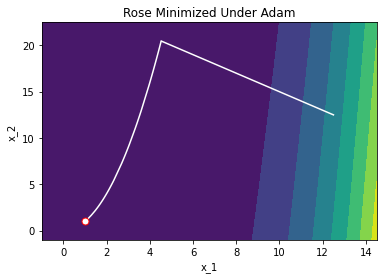

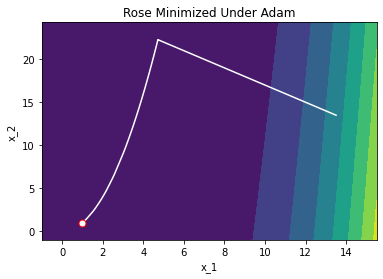

In [ ]:
testFunctionDesc(minirosenbrock,gradminiRose,"Rose",x=np.array([12.5,12.5]),tol=1e-20,iter=1e5)
testFunctionDesc(minirosenbrock,gradminiRose,"Rose",x=np.array([13.5,13.5]),tol=1e-20,iter=1e5)

Rastrig


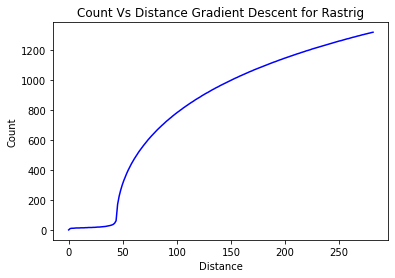

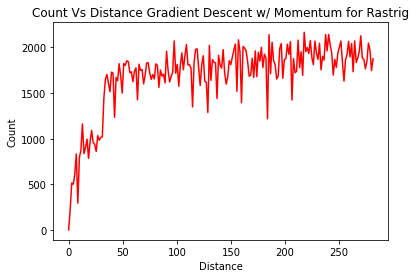

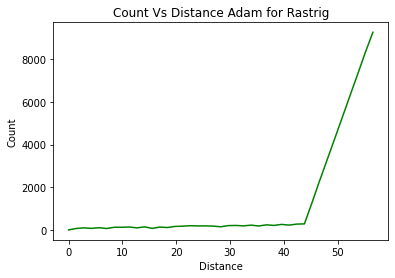

In [ ]:
testIterationsByDistance(rastrig,gradRas,"Rastrig",200,x0=np.array([0,0]))

Rastrig


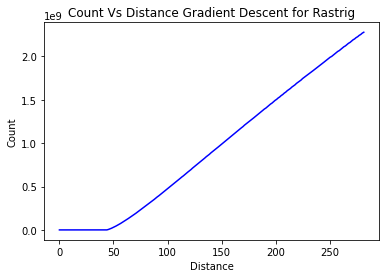

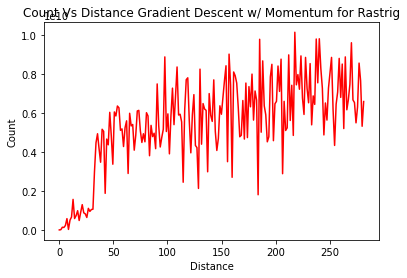

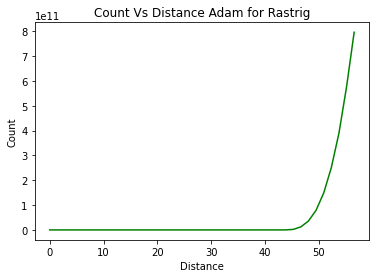

In [ ]:
testIterationsPowByDistance(rastrig,gradRas,"Rastrig",200,x0=np.array([0,0]),pow=3)

Rastrig


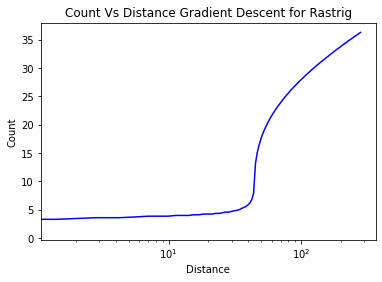

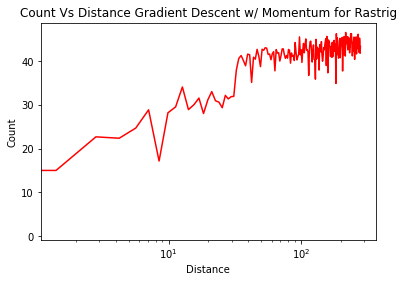

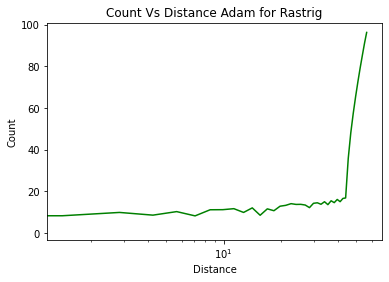

In [ ]:
testIterationsPowByDistance(rastrig,gradRas,"Rastrig",200,x0=np.array([0,0]),pow=.5,xlog=True)

Rastrig


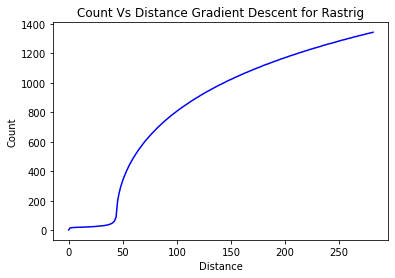

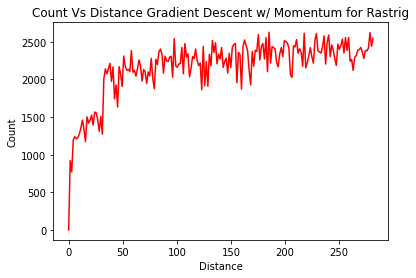

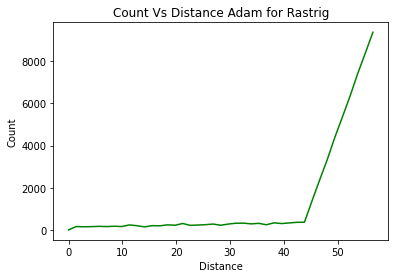

Rastrig
(1911.0688483808433, array([30.78204995, 30.78204995]))
(31.83859451589489, array([-3.9792626, -3.9792626]))
(1911.0688484142868, array([30.78199471, 30.78199471]))


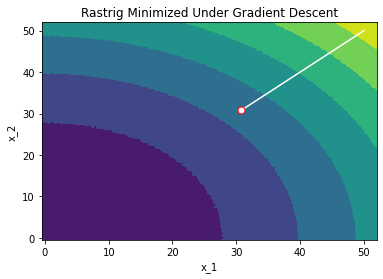

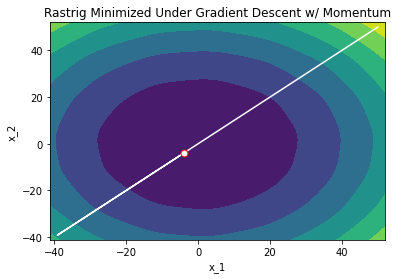

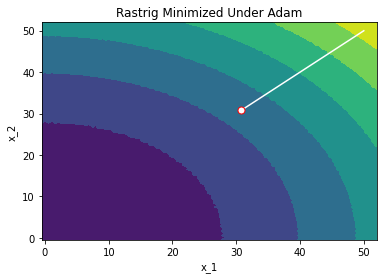

In [ ]:
testIterationsByDistance(rastrig,gradRas,"Rastrig",200,tol=1e-8,x0=np.array([0,0]))
testFunctionDesc(rastrig,gradRas,"Rastrig",x=np.array([50,50]),tol=1e-8,iter=1e5)

Spher


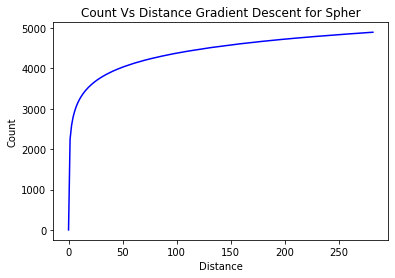

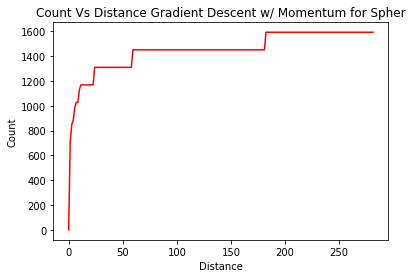

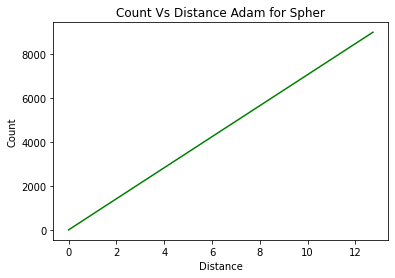

In [ ]:
testIterationsByDistance(spher,gradSpher,"Spher",200,x0=np.array([0,0]))

Spher


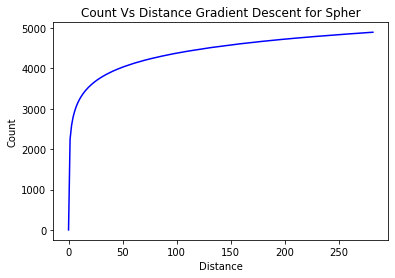

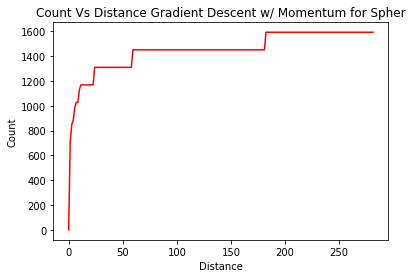

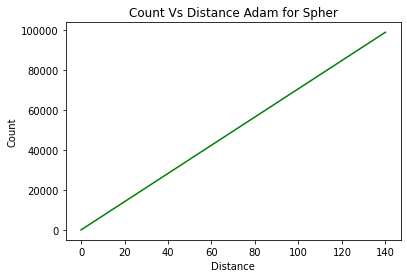

In [ ]:
testIterationsByDistance(spher,gradSpher,"Spher",200,x0=np.array([0,0]),iter=1e5)

Spher


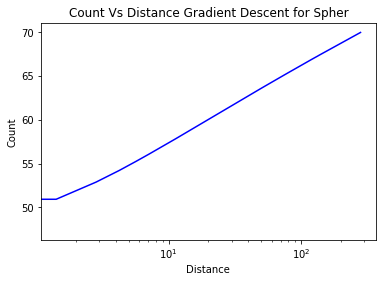

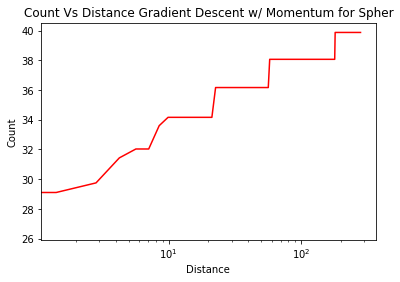

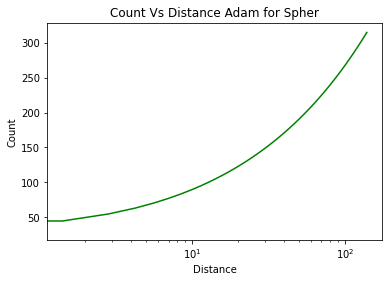

In [ ]:
testIterationsPowByDistance(spher,gradSpher,"Spher",200,x0=np.array([1,1]),iter=1e5,pow=.5,xlog=True)